In [1]:
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke
from matplotlib import gridspec
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import pickle
import json
import os
import shutil
import sys
sys.path.append("..")

from main import *

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

with open("../swarmalatorlib/hex_colors.json", "r", encoding="utf-8") as f:
    hexColors = json.load(f)
hexCmap = mcolors.LinearSegmentedColormap.from_list("cmap", hexColors)


import seaborn as sns

sns.set_theme(
    font="FandolSong",
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'axes.grid': True,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000',
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'axes.spines.right': False,
    'axes.spines.top': False,
})

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
#plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from multiprocessing import Pool
import pandas as pd

colors = ["#403990", "#3A76D6", "#FFC001", "#F46F43", "#FF0000"]
cmap = mcolors.LinearSegmentedColormap.from_list("cmap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

colors = ["#403990", "#80A6E2", "#F46F43", "#CF3D3E"]
cmap2 = mcolors.LinearSegmentedColormap.from_list("cmap2", colors)

SAVE_PATH = r"F:\MS_ExperimentData\general"
MP4_PATH = r"F:\MS_ExperimentData\mp4"

# SAVE_PATH = r"D:\MS_ExperimentData\general"
# MP4_PATH = r"D:\MS_ExperimentData\mp4"

# LOCAL_FIG_PATH = "./PCT_C_figs"
LOCAL_FIG_PATH = "./figs"


In [2]:
self = model = Frustration3D(strengthA=1.667, strengthB=1.667, 
                             distanceD0=0.917, phaseLagAlpha0=2.827,
                             boundaryLength=10,
                             tqdm=True, savePath=None, shotsnaps=5, dt=0.01)

In [3]:
model.run(10000) 

  0%|          | 0/10000 [00:00<?, ?it/s]

In [10]:
@nb.njit
def _update(positionX: np.ndarray, phaseSigma: np.ndarray,
            dotPos: np.ndarray, dotPhase: np.ndarray, dt: float,
            boundaryLength: float) -> Tuple[np.ndarray, np.ndarray]:
    positionX = (positionX + dotPos * dt) % boundaryLength
    phaseSigma = phaseSigma + dotPhase * dt
    norm = np.sqrt((phaseSigma**2).sum(axis=1)).reshape(-1, 1)
    phaseSigma = phaseSigma / norm
    return positionX, phaseSigma

dotPos = self.dotPosition
dotPhase = self.dotPhase

In [12]:
_update(
    self.positionX, self.phaseSigma, dotPos, dotPhase, self.dt, self.boundaryLength
)

(array([[7.74054899, 0.19774152, 6.34401733],
        [7.50476111, 4.9925838 , 2.27171324],
        [1.97930513, 7.6039343 , 1.66116903],
        ...,
        [4.8064196 , 9.12506349, 0.53350939],
        [7.02127981, 0.39434353, 1.39943013],
        [1.8349573 , 7.42637836, 9.19913402]], shape=(1000, 3)),
 array([[ 0.90803834, -0.33423914,  0.25248874],
        [ 0.55376006,  0.24934491,  0.79446643],
        [-0.04392172, -0.04542368, -0.99800179],
        ...,
        [ 0.3219165 , -0.06857038, -0.94428167],
        [-0.63466448,  0.44819816,  0.62953904],
        [-0.31892386,  0.87137146, -0.37282617]], shape=(1000, 3)))

In [6]:
np.linalg.norm(model.phaseSigma)

np.float64(inf)

In [5]:
25 * 11 / 40 * 3

20.625

In [ ]:
sa = StateAnalysis3D(model)
# colorIdxs = np.argsort(
#     #   sa.totalPositionX[0, :, 0] * model.agentsNum**2 
#     + sa.totalPositionX[0, :, 1] * model.agentsNum 
#     # + sa.totalPositionX[0, :, 2]
# )
colorIdxs = np.argsort(sa.totalPhaseSigma[0].mean(axis=1))

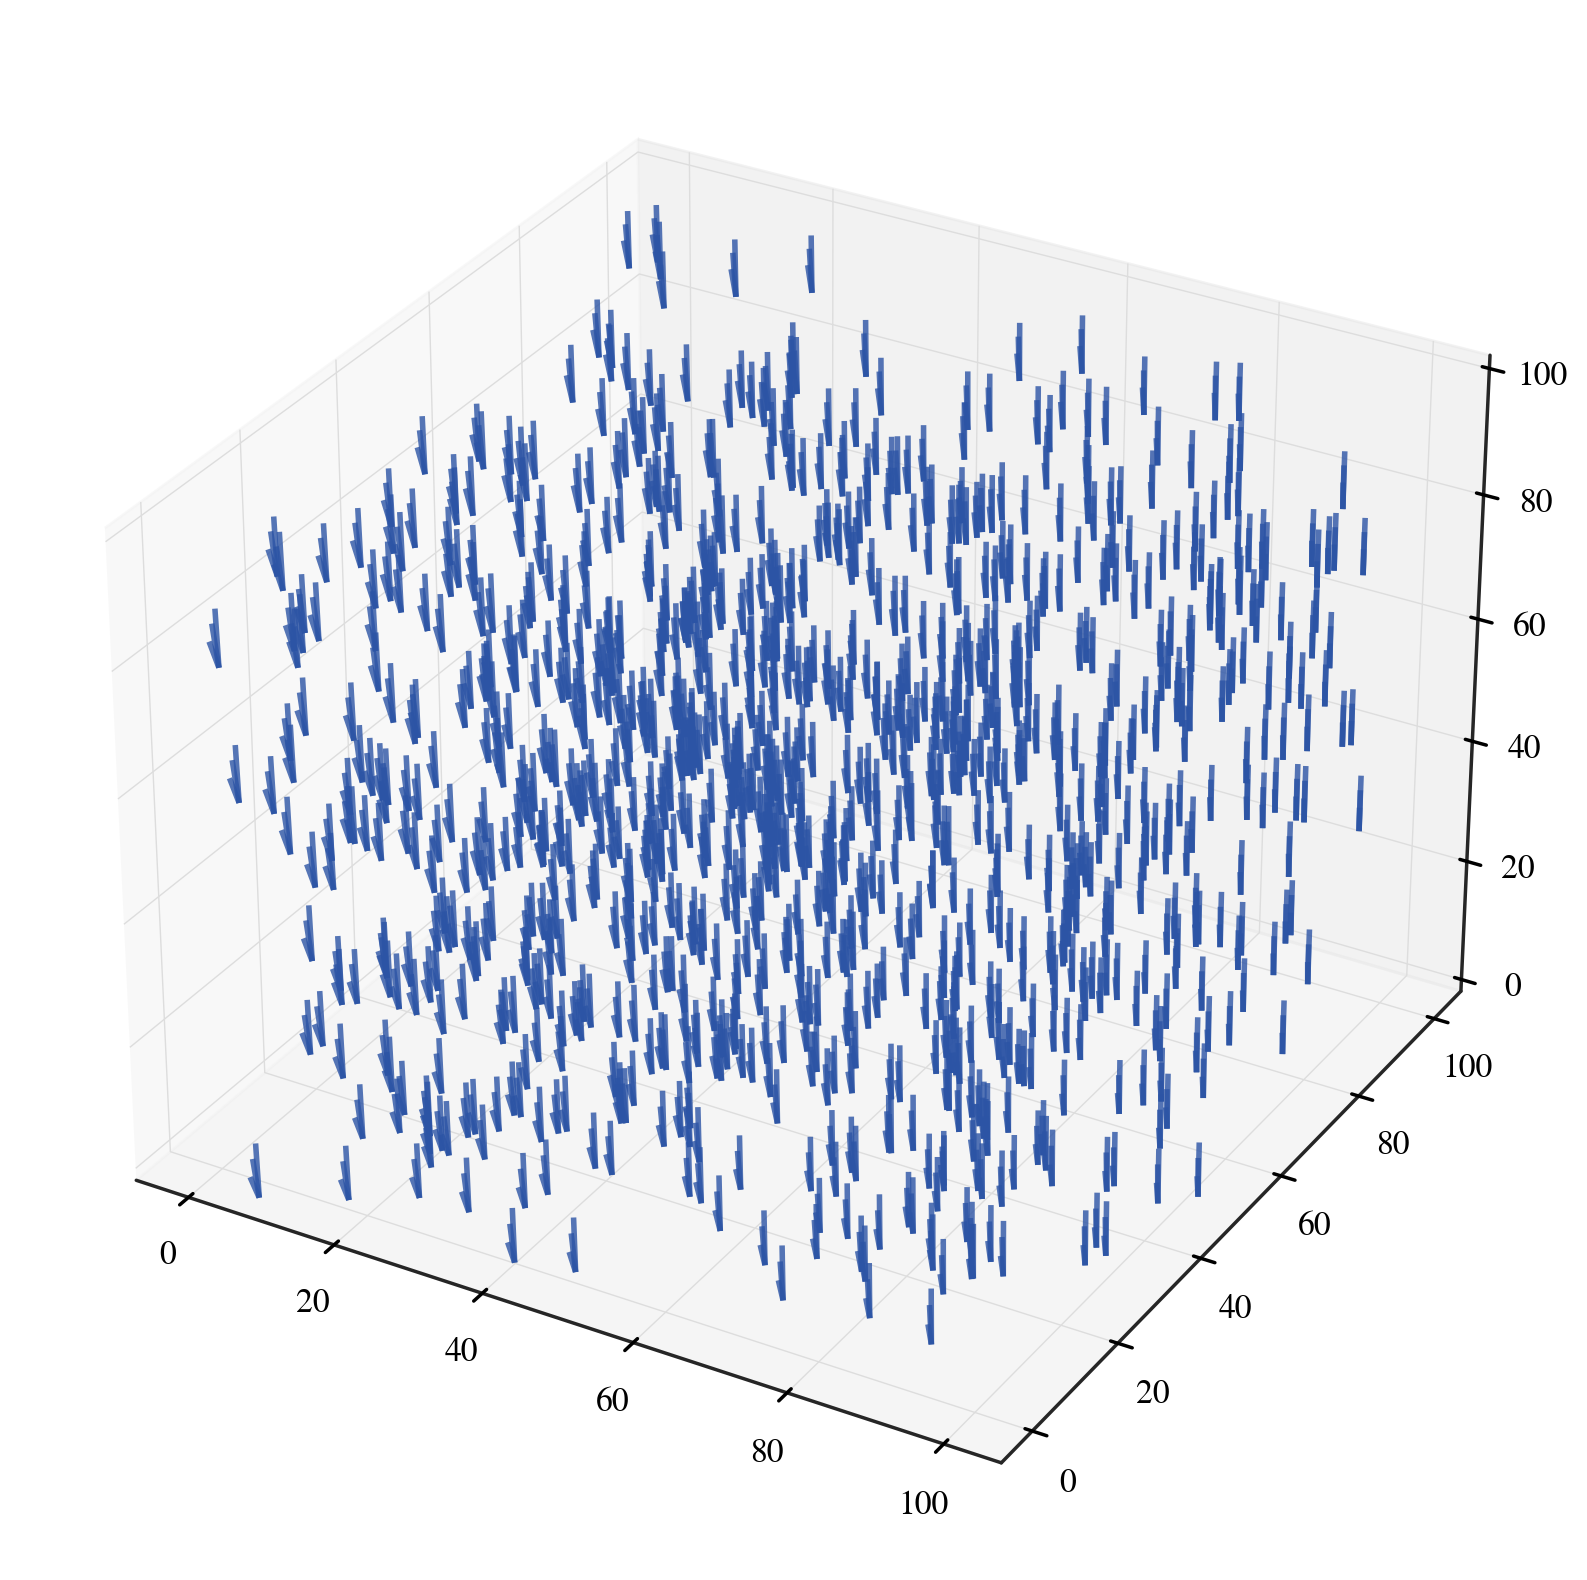

In [90]:
from matplotlib.colors import Normalize

def vectors_to_cmap_colors(vectors):
    x, y, z = vectors.T
    phi = np.arctan2(y, x)  # 方位角 [-π, π]
    phi[phi < 0] += 2 * np.pi  # 转到 [0, 2π)
    phi_norm = phi / (2 * np.pi)  # 归一化到 [0,1]
    
    norm = Normalize(vmin=0, vmax=1)
    colors = hexCmap(norm(phi_norm))
    return colors

# positionX, phaseSigma = sa.get_state(-1)
positionX, phaseSigma = model.positionX, model.phaseSigma
# colorIdxs = np.argsort(phaseSigma.mean(axis=1))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

colors = vectors_to_cmap_colors(phaseSigma)
for i in range(len(colors)):
    ax.quiver(X=positionX[i, 0], Y=positionX[i, 1], Z=positionX[i, 2],
              U=phaseSigma[i, 0], V=phaseSigma[i, 1], W=phaseSigma[i, 2],
              colors=colors[i],
              alpha=0.8, length=10, arrow_length_ratio=1, linewidths=2)
# ax.scatter(model.positionX[:, 0], model.positionX[:, 1], model.positionX[:, 2])

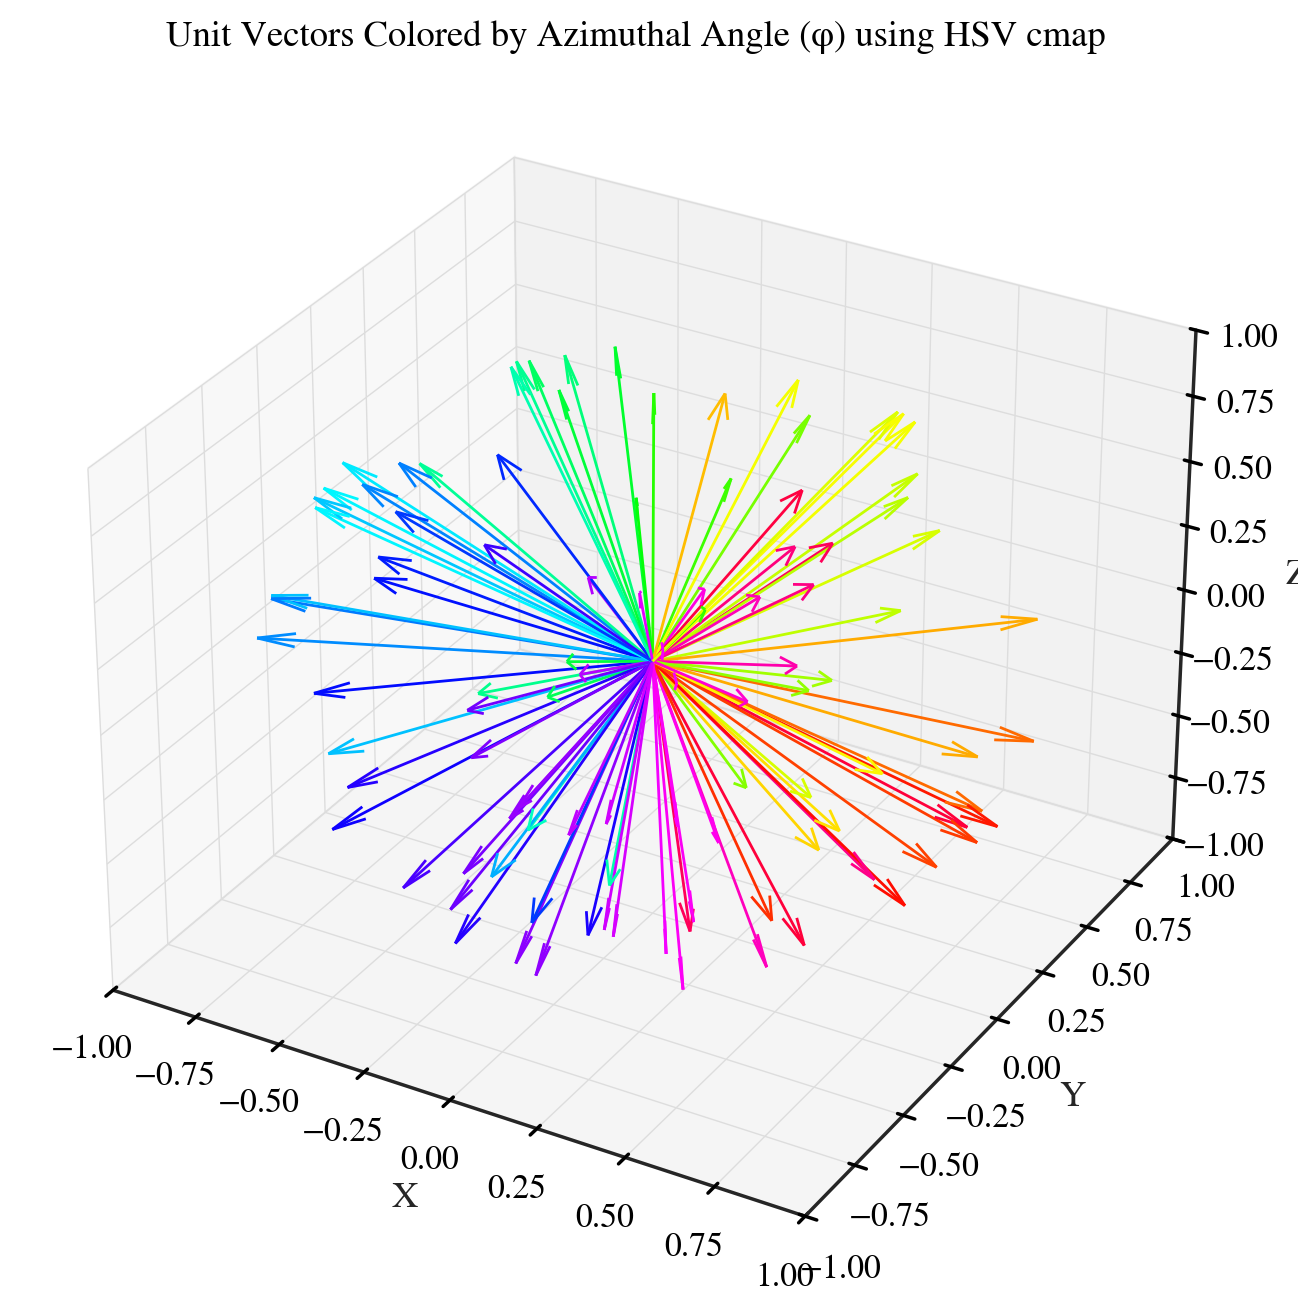

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D

def vectors_to_cmap_colors(vectors, cmap_name='hsv'):
    """
    将单位向量映射到 colormap 的颜色（仅用方位角 phi）。
    
    参数：
        vectors: (N, 3) 数组，单位向量。
        cmap_name: matplotlib colormap 名称（如 'hsv', 'viridis', 'plasma'）。
    
    返回：
        colors: (N, 4) RGBA 数组（范围 [0,1]）。
    """
    x, y, z = vectors.T
    phi = np.arctan2(y, x)  # 方位角 [-π, π]
    phi[phi < 0] += 2 * np.pi  # 转到 [0, 2π)
    phi_norm = phi / (2 * np.pi)  # 归一化到 [0,1]
    
    # 使用 colormap 映射
    cmap = plt.get_cmap(cmap_name)
    norm = Normalize(vmin=0, vmax=1)
    colors = cmap(norm(phi_norm))
    return colors

# 生成随机单位向量
np.random.seed(42)
N = 100
random_points = np.random.randn(N, 3)
unit_vectors = random_points / np.linalg.norm(random_points, axis=1, keepdims=True)

# 映射到颜色（使用 'hsv' colormap）
colors = vectors_to_cmap_colors(unit_vectors, cmap_name='hsv')

# 可视化
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制单位向量（从原点出发）
ax.quiver(
    np.zeros(N), np.zeros(N), np.zeros(N),
    unit_vectors[:, 0], unit_vectors[:, 1], unit_vectors[:, 2],
    color=colors, length=1.0, arrow_length_ratio=0.1, linewidths=1
)

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Unit Vectors Colored by Azimuthal Angle (φ) using HSV cmap')

plt.show()